In [1]:
import numpy as np
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import random
from scipy.stats import norm

from multiprocessing import Pool
from itertools import permutations
import os
import pathlib
from tqdm import tqdm
# from Model import *
# from utils import *

torch.autograd.set_detect_anomaly(True)

In [3]:
s='''self.loss=loss
        self.target_type='indicator' if (pop1_dict['GlobalParams'].target_type=='indicator' and pop1_dict['GlobalParams'].trick!='logit') else "sigmoid"
        self.delta=pop1_dict['GlobalParams'].delta
        self.K=pop1_dict['GlobalParams'].K
        self.w=pop1_dict['GlobalParams'].w
        self.NT1=pop1_dict['GlobalParams'].NT1
        self.NT2=pop1_dict['GlobalParams'].NT2
        self.dt=pop1_dict['GlobalParams'].dt
        self.t = np.array([i for i in range(self.NT2+1)]) * self.dt
        self.NumTrain=pop1_dict['GlobalParams'].NumTrain
        self.number_of_paths=np.minimum(PlotPaths,self.NumTrain)
        self.seed=seed
        ## -------------------------------- P1 Params -------------------------------- ##
        self.GlobalParams1=pop1_dict['GlobalParams']
        self.h1=pop1_dict['GlobalParams'].h
        ## -------------------------------- P2 Params -------------------------------- ##
        self.GlobalParams2=pop2_dict['GlobalParams']
        self.h2=pop2_dict['GlobalParams'].h

        ## -------------------------------- Process Paths -------------------------------- ##
        self.pop1_path_dict,self.pop2_path_dict=get_target_path(pop1_dict, pop2_dict)
        torch.manual_seed(self.seed)
        idx_list = np.random.choice(self.NumTrain, self.number_of_paths, replace = False)
        self.pop1_plot = {k:v.detach().numpy()[idx_list] for k,v in self.pop1_path_dict.items() if v.shape[0]==self.NumTrain}
        self.pop2_plot = {k:v.detach().numpy()[idx_list] for k,v in self.pop2_path_dict.items() if v.shape[0]==self.NumTrain}
        self.pop1_plot.update({k:v.detach().numpy() for k,v in self.pop1_path_dict.items() if v.shape[0]!=self.NumTrain})
        self.pop2_plot.update({k:v.detach().numpy() for k,v in self.pop2_path_dict.items() if v.shape[0]!=self.NumTrain})
    '''
s

'self.loss=loss\n        self.target_type=\'indicator\' if (pop1_dict[\'GlobalParams\'].target_type==\'indicator\' and pop1_dict[\'GlobalParams\'].trick!=\'logit\') else "sigmoid"\n        self.delta=pop1_dict[\'GlobalParams\'].delta\n        self.K=pop1_dict[\'GlobalParams\'].K\n        self.w=pop1_dict[\'GlobalParams\'].w\n        self.NT1=pop1_dict[\'GlobalParams\'].NT1\n        self.NT2=pop1_dict[\'GlobalParams\'].NT2\n        self.dt=pop1_dict[\'GlobalParams\'].dt\n        self.t = np.array([i for i in range(self.NT2+1)]) * self.dt\n        self.NumTrain=pop1_dict[\'GlobalParams\'].NumTrain\n        self.number_of_paths=np.minimum(PlotPaths,self.NumTrain)\n        self.seed=seed\n        ## -------------------------------- P1 Params -------------------------------- ##\n        self.GlobalParams1=pop1_dict[\'GlobalParams\']\n        self.h1=pop1_dict[\'GlobalParams\'].h\n        ## -------------------------------- P2 Params -------------------------------- ##\n        self.GlobalPa

In [19]:
import re 
res=re.findall(r"self.(\w+?)\s*?=",s)
for i in res:
    print(f"- __{i}__ (_ ")


- __loss__ (_ 
- __target_type__ (_ 
- __delta__ (_ 
- __K__ (_ 
- __w__ (_ 
- __NT1__ (_ 
- __NT2__ (_ 
- __dt__ (_ 
- __t__ (_ 
- __NumTrain__ (_ 
- __number_of_paths__ (_ 
- __seed__ (_ 
- __GlobalParams1__ (_ 
- __h1__ (_ 
- __GlobalParams2__ (_ 
- __h2__ (_ 
- __pop2_path_dict__ (_ 
- __pop1_plot__ (_ 
- __pop2_plot__ (_ 


# Problem & Objective
$\displaystyle{
    \begin{align}
    &F(g,~\Gamma,~a,~X):=\mathbb{E}\left[\int_0^{T_2}{\frac{1}{2}\left(\left(\xi{g_t}^2dt+\gamma{\Gamma_t}^2+\beta{a_t}^2\right)+S_t\Gamma_t\right)dt+w(K-X_{T_1})_+ + w\left(K-X_{T_2}+X_{T_1}-(X_{T_1}-K)_+\right)_+}\right]\\
    &\mathcal{J}(g,~\Gamma,~a,~X):=\inf_{g,~\Gamma,~a} F(g,~\Gamma,~a,~X)\\
    \end{align}
}$, where: 

$\displaystyle{
    \begin{align}
        \underset{N\rightarrow\infty}{\lim}{\frac{1}{N}\sum\limits_{i=1}^{N}{\Gamma_t^{(i)}} \&=0}\\
        \
        dX_t=\left(h+g_t+\Gamma_t+ C_t \right)dt+\sigma dB_t, ~~~~&X_0 \sim \xi=\mathcal{N}(v,\eta)\\
        \
        dC_t=a_tdt, ~~~~&C_0=0\\
    \end{align}
}$

And by differentiating $X$ w.r.t. $g$ and $\Gamma$ in an arbitrary direction $\eta$:

$\displaystyle{
    \begin{align}
        &\partial_g X_t = \int_0^t{\eta_sds}\\
        &\partial_{\Gamma} X_t = \int_0^t{\eta_sds} \\
    \end{align}
}$

Differentiate $X$ and $C$ w.r.t. $a$ in an arbitrary direction $\eta$:

$\displaystyle{
    \begin{align}
        &\partial_a C_t = \int_0^t{\eta_sds}\\
        &\partial_a X_t = \int_0^t{\partial_a C_s ds} = \int_0^t{\int_0^s{\eta_u du}~ds} \\
    \end{align}
}$

Thus, differentiate $\mathcal{J}$ w.r.t. $g$ in an arbitrary direction $\eta$ and by iterating expectations:

$$\displaystyle{
    \begin{align}
        \partial_g\mathcal{J}(g,~\Gamma,~a,~\eta) 
        &= \Bbb{E}\left[
            \int_0^{T_2}{\xi g_t \eta_t}~dt-w\mathbb I_{\scriptstyle {X_{T_1}<K}}\partial_g X_{T_1}-w\mathbb I_{\scriptstyle {X_{T_2}-X_{T_1}+(X_{T_1}-K)_+ < K}}\left(\partial_g X_{T_2}-\partial_g X_{T_1}+\mathbb I_{\scriptstyle {X_{T_1}>K}}\partial_g X_{T_1}\right)
            \right]\\
        &= \Bbb{E} \Biggl[
            \int_0^{T_1}{\left( \xi g_t -w \mathbb I_{\scriptstyle {X_{T_1}<K}}-w \mathbb I_{\scriptstyle {X_{T_2}-X_{T_1}+(X_{T_1}-K)_+ < K}}\right)\eta_t }dt\\
        &~~~~~~~~+ \int_{T_1}^{T_2}{\left( \xi g_t -w \mathbb I_{\scriptstyle {X_{T_2}-X_{T_1}+(X_{T_1}-K)_+ < K}}\right)\eta_t }dt 
        \Biggr]\\
        &=\Bbb{E} \Biggl[\int_0^{T_1}{\left( \xi g_t -w\Bbb E\left[\Bbb I_{\scriptstyle {X_{T_1}<K}}|\mathcal F_t\right] -w\Bbb E\left[\Bbb I_{\scriptstyle {X_{T_2}-X_{T_1}+(X_{T_1}-K)_+ < K}}|\mathcal{F}_t\right] \right)\eta_t }dt \\
        &~~~~~~~~+ \int_{T_1}^{T_2}{\left( \xi g_t -w\Bbb E\left[\Bbb I_{\scriptstyle {X_{T_2}-X_{T_1}+(X_{T_1}-K)_+ < K}}|\mathcal{F}_t\right]\right)\eta_t }dt \Biggr]\\
        &= \Bbb{E} \Biggl[\int_0^{T_1}{\left( \xi g_t -w\Bbb P\left(X_{T_1}<K|\mathcal F_t\right) -w\Bbb P\left(X_{T_2}-X_{T_1}+(X_{T_1}-K)_+ < K|\mathcal{F}_t\right) \right)\eta_t }dt\\
        &~~~~~~~~+ \int_{T_1}^{T_2}{\left( \xi g_t -w\Bbb P\left(X_{T_2}-X_{T_1}+(X_{T_1}-K)_+ < K|\mathcal{F}_t \right) \right)\eta_t }dt \Biggr]\\
        &=0\\
    \end{align}
}$$ 
for all $\eta$ when $g$ is optimal. So we get the first order condition of $g_t$:

$$
\begin{align}
    g_t &= \frac{w \left[\Bbb P \left( X_{T_1}<K|\mathcal F_t \right) + \Bbb P\left(X_{T_2}-X_{T_1}+\left(X_{T_1}-K\right)_+ < K|\mathcal{F}_t\right)\right]}{\xi}~\Bbb{I}_{t \in [0,T_1)} \\
    &~~~~+~~ \frac{w\Bbb {P}\left(X_{T_2}-X_{T_1}+(X_{T_1}-K)_+ < K|\mathcal{F}_t \right)}{\xi}~\Bbb{I}_{t \in [T_1,T_2]}\\
\end{align}
$$

Here we have 2 options: 1) either choose the target to be indicator functions themselves 2) or weighted/scaled indicator functions (i.e., $w~\Bbb I( \cdot ), ~ 0<w<1$). Since when scaled, the loss function will see smaller target values, leading to smaller error gradients and more stable updates, avoiding large oscillations. Thus by scaling/weighting the target indicator functions, we can achieve a smoother convergence process and greater convergence rate. 

Hence, $g$ can be written as:

$\displaystyle{
    \begin{align}
        g_t =\frac{V_t+U_t}{\xi}~\Bbb{I}_{t \in [0,T_1)} + \frac{Y_t}{\xi}~\Bbb{I}_{t \in [T_1,T_2]}\\
    \end{align}
}$, where

$\displaystyle{
    \begin{align}
        V_t &= \Bbb{E} \left[w \mathbb I_{\scriptstyle {X_{T_1}<K}}|\mathcal F_t \right] \ &&= w\Bbb{P}\left( X_{T_1}<K |\mathcal F_t\right)\\
        U_t &= \Bbb{E} \left[w\mathbb I_{\scriptstyle {X_{T_1}>K,~X_{T_2}-X_{T_1}+(X_{T_1}-K)_+ < K}}|\mathcal F_t \right] \ &&= w\Bbb{P}\left( X_{T_1}>K,~X_{T_2} < 2K|\mathcal F_t\right)\\
        Y_t &= \Bbb{E} \left[w\mathbb I_{\scriptstyle {X_{T_2}-X_{T_1}+(X_{T_1}-K)_+ < K}}|\mathcal F_t \right] \ &&= w\Bbb{P}\left( X_{T_2}-X_{T_1}+(X_{T_1}-K)_+ < K|\mathcal F_t\right)\\
    \end{align}
}$

Similarly, we differentitate $\mathcal{J}$ w.r.t. $\Gamma$ and $a$ in an arbitrary direction $\eta$ and apply iterating expectations, arguing that all $\eta$ terms should be 0 for any $\eta$. Thus we get the following first order conditions:

$$\displaystyle{
    \begin{align}
        \Gamma_t &=\frac{V_t+U_t-S_t}{\gamma}~\Bbb{I}_{t \in [0,T_1)} + \frac{Y_t-S_t}{\gamma}~\Bbb{I}_{t \in [T_1,T_2]}\\
        a_t &=\frac{\left(T_1-t\right)\left(V_t+U_t\right)+\left(T_2-T_1\right)Y_t}{\beta}~\Bbb{I}_{t \in [0,T_1)} + \frac{\left(T_2-t\right)Y_t}{\beta}~\Bbb{I}_{t \in [T_1,T_2]}\\
    \end{align}
}$$

Enforcing the Equilibrium Market Clearing Condition ar optimality:

$$\displaystyle{
    \begin{align}
        &~~~~\lim_{N\rightarrow \infty}{\frac{1}{N}\sum\limits_{i=1}^{N}\Gamma^{(i)}}\\
        &=\lim_{N\rightarrow \infty}{
            \frac{1}{N}\sum\limits_{i=1}^{N}{
                \frac{1}{\gamma}\left[
                    \left(V_t^{(i)}+U_t^{(i)}-S_t\right)~\Bbb{I}_{t \in [0,T_1)} +\left(Y_t^{(i)}-S_t\right)~\Bbb{I}_{t \in [T_1,T_2]}
                    \right]
                }
            }\\
        &=0
    \end{align}
}$$

Thus, we get the market clearing price as follows:

$$
\begin{align}
    S_t = \Bbb{E}\left[V_t+U_t\right] ~\Bbb{I}_{t \in [0,T_1)} + \Bbb{E}\left[Y_t\right] ~\Bbb{I}_{t \in [T_1,T_2]}
\end{align}
$$

So putting all these together and extending to the 2-population scenario ($k \in \{1,2\}$):

$$
\begin{align}
& g_t^{(k)} =\  \frac{V_t^{(k)}+U_t^{(k)}}{\zeta^{(k)}} ~\Bbb{I}_{t\in [0,T_1)}
            + \frac{Y_t^{(k)}}{\zeta^{(k)}} ~\Bbb{I}_{t\in [T_1,T_2]} \\
& \Gamma_t^{(k)} =\  \frac{V_t^{(k)}+U_t^{(k)}-S_t}{\gamma^{(k)}} ~\Bbb{I}_{t\in [0,T_1)}
                 + \frac{Y_t^{(k)}-S^t}{\gamma^{(k)}} ~\Bbb{I}_{t\in [T_1,T_2]} \\
& a_t^{(k)} =\  \frac{(T_1-t)(V_t^{(k)}+U_t^{(k)})+(T_2-T_1)Y_t}{\beta^{(k)}} ~\Bbb{I}_{t\in [0,T_1)}
            + \frac{(T_2-t)Y_t^{(k)}}{\beta^{(k)}} ~\Bbb{I}_{t\in [T_1,T_2]} \\
& S_t =\  \Biggl(
                \frac{\frac{\pi_1}{\gamma_1}}{\frac{\pi_1}{\gamma_1}+\frac{\pi_2}{\gamma_2}}\mathbb{E}[V_t^{(1)}+U_t^{(1)}]+\frac{\frac{\pi_2}{\gamma_2}}{\frac{\pi_1}{\gamma_1}+\frac{\pi_2}{\gamma_2}}\mathbb{E}[V_t^{(2)}+U_t^{(2)}]
            \Biggr) ~\Bbb{I}_{t\in [0,T_1)}\\
            &~~~~~~~~+ \Biggl(
                        \frac{\frac{\pi_1}{\gamma_1}}{\frac{\pi_1}{\gamma_1}+\frac{\pi_2}{\gamma_2}}\mathbb{E}[Y_t^{(1)}]+\frac{\frac{\pi_2}{\gamma_2}}{\frac{\pi_1}{\gamma_1}+\frac{\pi_2}{\gamma_2}}\mathbb{E}[Y_t^{(2)}]
                        \Biggr) ~\Bbb{I}_{t\in [T_1,T_2]} \\
\end{align}
\\
\begin{cases}
    dX_t^{(K)} &=(h^{(k)}+g_t^{(k)}+\Gamma_t^{(k)}+C_t^{(k)})dt + \sigma^{(k)}dW_t^{(k)}\ &&, \ &X_0^{(k)} \sim \xi^{(k)}\\
    dC_t^{(k)} &= a_t^{(k)}dt\ &&, \ &C_0^{(k)}=0 \\ 
    dV_t^{(k)} &= Z_t^{V,(k)}dW_t^{(k)}\ &&, \ &V_{T_1}^{(k)}=w*\mathbb{I}_{X_{T_1}<K} \\
    dU_t^{(k)} &= Z_t^{U,(k)}dW_t^{(k)}\ &&, \ &U_{T_1}^{(k)}=1*Y_{T_1}\mathbb{I}_{X_{T_1}>K}\\
    dY_t^{(k)} &= Z_t^{Y,(k)}dW_t^{(k)}\ &&, \ &Y_{T_2}^{(k)}=w*\mathbb{I}_{X_{T_2}-X_{T_1}+(X_{T_1}-K)_+<K}
\end{cases}
$$


In [19]:
display(Math(r'F(k) = \int_{-\infty}^{\infty} f(x) e^{2\pi i k} dx'))

<IPython.core.display.Math object>

## 2-Period Conditions

$\displaystyle {g_t^{(k)}=\frac{V_t^{(k)}+U_t^{(k)}}{\zeta^{(k)}}\mathbb{I}_{t\in [0,T_1]}+\frac{Y_t^{(k)}}{\zeta^{(k)}}\mathbb{I}_{t\in [T_1,T_2]}}$

$\displaystyle {\Gamma_t^{(k)}=\frac{V_t^{(k)}+U_t^{(k)}-S_t}{\gamma^{(k)}}\mathbb{I}_{t\in [0,T_1]}+\frac{Y_t^{(k)}-S^t}{\gamma^{(k)}}\mathbb{I}_{t\in [T_1,T_2]}}$

$\displaystyle {a_t^{(k)}=\frac{(T_1-t)(V_t^{(k)}+U_t^{(k)})+(T_2-T_1)Y_t}{\beta^{(k)}}\mathbb{I}_{t\in [0,T_1]}+\frac{(T_2-t)Y_t^{(k)}}{\beta^{(k)}}\mathbb{I}_{t\in [T_1,T_2]}}$

$\displaystyle {\begin{align}S_t &=(\frac{\frac{\pi_1}{\gamma_1}}{\frac{\pi_1}{\gamma_1}+\frac{\pi_2}{\gamma_2}}\mathbb{E}[V_t^1+U_t^1]+\frac{\frac{\pi_2}{\gamma_2}}{\frac{\pi_1}{\gamma_1}+\frac{\pi_2}{\gamma_2}}\mathbb{E}[V_t^2+U_t^2])\mathbb{I}_{t\in [0,T_1]}+(\frac{\frac{\pi_1}{\gamma_1}}{\frac{\pi_1}{\gamma_1}+\frac{\pi_2}{\gamma_2}}\mathbb{E}[Y_t^1]+\frac{\frac{\pi_2}{\gamma_2}}{\frac{\pi_1}{\gamma_1}+\frac{\pi_2}{\gamma_2}}\mathbb{E}[Y_t^2])\mathbb{I}_{t\in [T_1,T_2]}\\ &=(\frac{\pi_1\gamma_2}{\pi_1\gamma_2+\\pi_2\gamma_1}\mathbb{E}[V_t^1+U_t^1]+\frac{\pi_2\gamma_1}{\pi_1\gamma_2+\\pi_2\gamma_1}\mathbb{E}[V_t^2+U_t^2])\mathbb{I}_{t\in [0,T_1]}+(\frac{\pi_1\gamma_2}{\pi_1\gamma_2+\\pi_2\gamma_1}\mathbb{E}[Y_t^1]+\frac{\pi_2\gamma_1}{\pi_1\gamma_2+\\pi_2\gamma_1}\mathbb{E}[Y_t^2])\mathbb{I}_{t\in [T_1,T_2]}\end{align}}$
<!-- \\ &\,\,\,\, -->

$\displaystyle {
    \begin{cases}
    dX_t^{(K)}&=(h^{(k)}+g_t^{(k)}+\Gamma_t^{(k)}+C_t^{(k)})dt + \sigma^{(k)}dW_t^{(k)}&, X_0^{(k)} \sim \xi^{(k)},~X_{T_1}' = (X_{T_1}-K)_+\\
    dC_t^{(k)} &= a_t^{(k)}dt&, C_0^{(k)}=0 \\ 
    dV_t^{(k)} &= Z_t^{V,(k)}dW_t^{(k)}&, V_{T_1}^{(k)}=\mathbb{I}_{X_{T_1}<K} \\
    dU_t^{(k)} &= Z_t^{U,(k)}dW_t^{(k)}&, U_{T_1}^{(k)}=Y_{T_1}\mathbb{I}_{X_{T_1}>K}\\
    dY_t^{(k)} &= Z_t^{Y,(k)}dW_t^{(k)}&, Y_{T_2}^{(k)}=\mathbb{I}_{X_{T_2}-X_{T_1}+(X_{T_1}-K)_+<K}
    \end{cases}}$


Should YT1 be restarted???? i.e. for 1Prd*2, y0_model() and y1_model().



## Create Models

In [2]:
#Global parameters
GlobalParams1=Params(param_type='k1',target_type='indicator',trick='logit',loss_type='BCEWithLogitsLoss',delta=0.03,w=0.5,lr=0.001)
dB1 = SampleBMIncr(GlobalParams=GlobalParams1)
init_x1 =  Sample_Init(GlobalParams=GlobalParams1)
init_c1= torch.zeros_like(init_x1)

GlobalParams2=Params(param_type='k2',target_type='indicator',trick='logit',loss_type='BCEWithLogitsLoss',delta=0.03,w=0.5,lr=0.001)
dB2 = SampleBMIncr(GlobalParams=GlobalParams2)   ## TODO: same dB?????
init_x2 =  Sample_Init(GlobalParams=GlobalParams2)
init_c2= torch.zeros_like(init_x2)

NT1=GlobalParams1.NT1
NT2=GlobalParams1.NT2
dt=GlobalParams1.dt
device=GlobalParams1.device
learning_rate = GlobalParams1.lr

#Forward Loss
forward_losses = []

#How many batches
MaxBatch= 500

#How many optimization steps per batch
OptimSteps= 25

#Train on a single batch?
single_batch = True

#Set up main models for y0 and z (z will be list of models)
v0_model_main1 = Network(scaler_type='minmax')
u0_model_main1 = Network(scaler_type='minmax')
y0_model_main1 = Network(scaler_type='minmax')

zv_models_main1 = [Network() for i in range(NT1)]
zu_models_main1 = [Network() for i in range(NT1)]
zy_models_main1 = [Network() for i in range(NT2)]
main_models1=Main_Models(GlobalParams=GlobalParams1)
main_models1.create(v0_model=v0_model_main1,
                    u0_model=u0_model_main1,
                    y0_model=y0_model_main1,
                    zv_models=zv_models_main1,
                    zu_models=zu_models_main1,
                    zy_models=zy_models_main1,
                    forward_loss=forward_losses,
                    dB=dB1,
                    init_x=init_x1,
                    init_c=init_c1)

v0_model_main2 = Network(scaler_type='minmax')
u0_model_main2 = Network(scaler_type='minmax')
y0_model_main2 = Network(scaler_type='minmax')

zv_models_main2 = [Network() for i in range(NT1)]
zu_models_main2 = [Network() for i in range(NT1)]
zy_models_main2 = [Network() for i in range(NT2)]
main_models2=Main_Models(GlobalParams=GlobalParams2)
main_models2.create(v0_model=v0_model_main2,
                    u0_model=u0_model_main2,
                    y0_model=y0_model_main2,
                    zv_models=zv_models_main2,
                    zu_models=zu_models_main2,
                    zy_models=zy_models_main2,
                    forward_loss=forward_losses,
                    dB=dB2,
                    init_x=init_x2,
                    init_c=init_c2)

pop1_dict={'dB':dB1,
           'init_x':init_x1 ,
           'init_c':init_c1 , 
           'GlobalParams':GlobalParams1, 
           'main_models':main_models1}

pop2_dict={'dB':dB2,
           'init_x':init_x2 ,
           'init_c':init_c2 , 
           'GlobalParams':GlobalParams2, 
           'main_models':main_models2}

In [5]:
model_dict1=main_models1.u0_model.state_dict()
model_dict1.keys()      

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])

<Axes: ylabel='Count'>

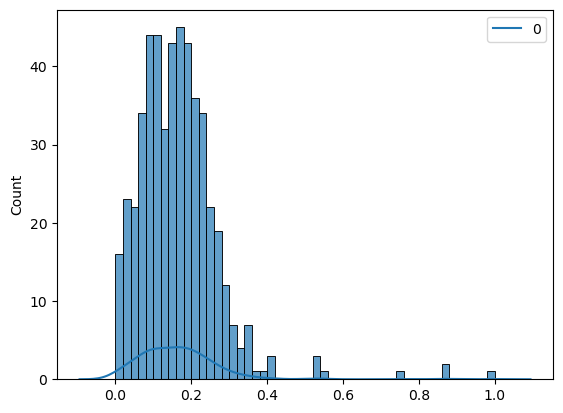

In [6]:
u0=(main_models1.u0_model(init_x2)).detach().numpy()
# w1=((u0-u0.amin())/(u0.amax()-u0.amin()))
sns.histplot(data=u0, bins=50,stat='count',alpha=0.7,color= 'grey')
sns.kdeplot(u0, color="green")


## Load Models

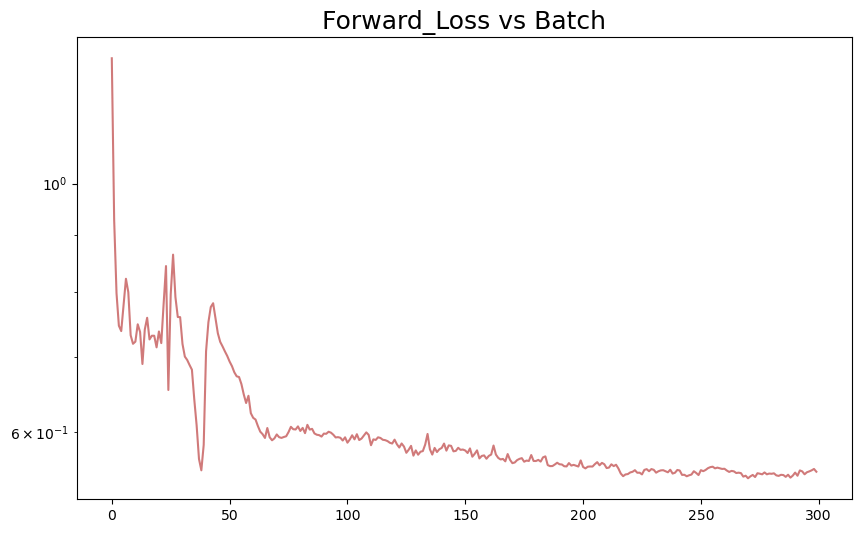

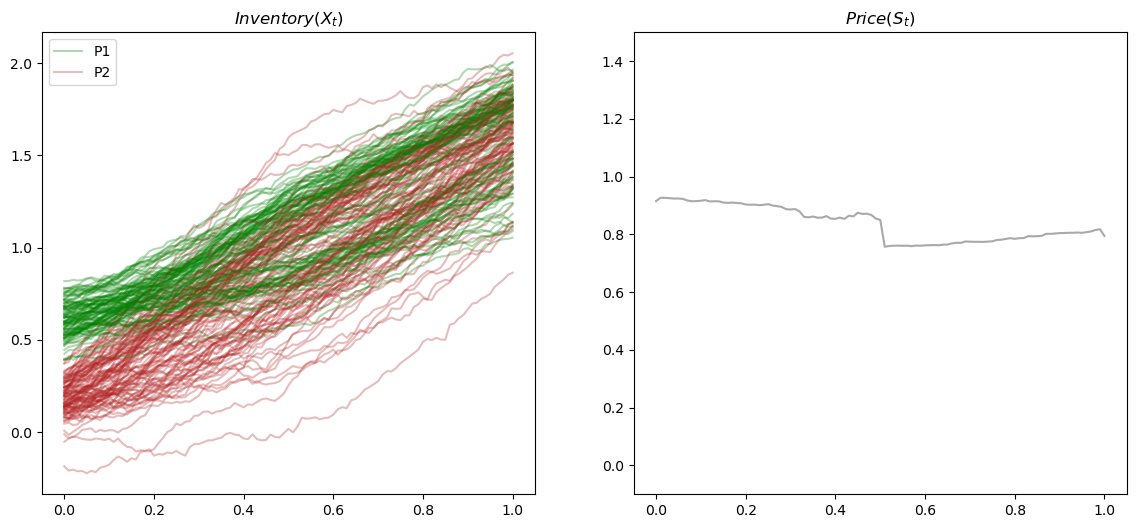

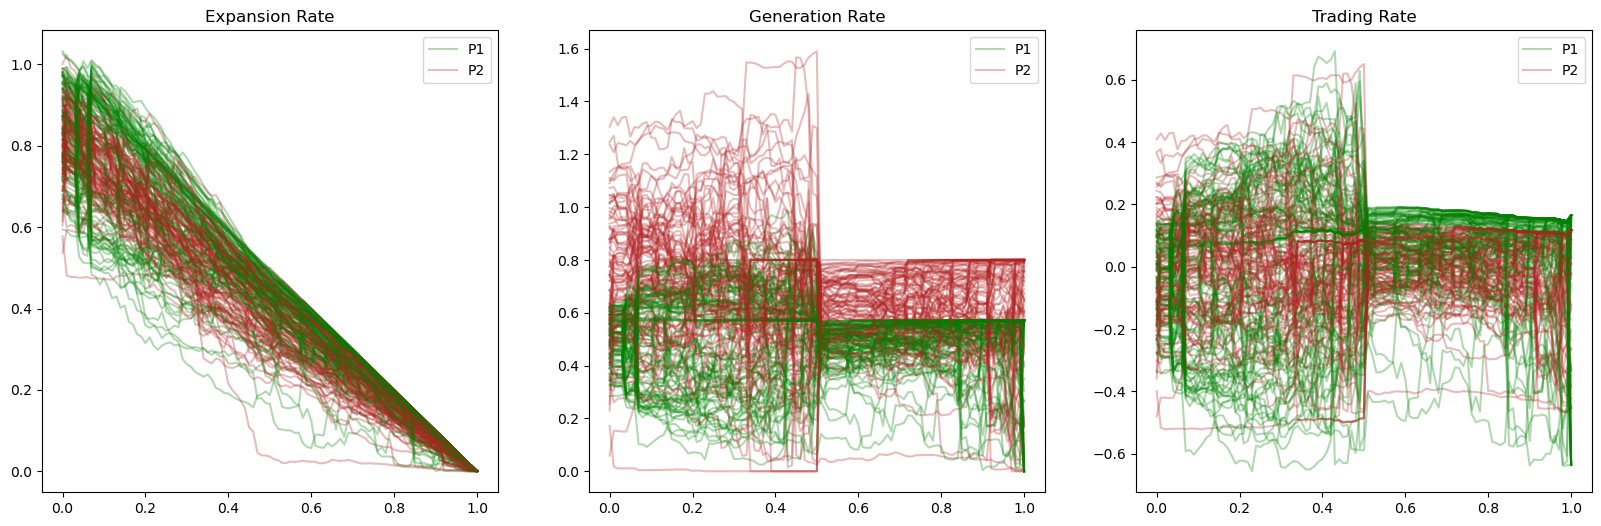

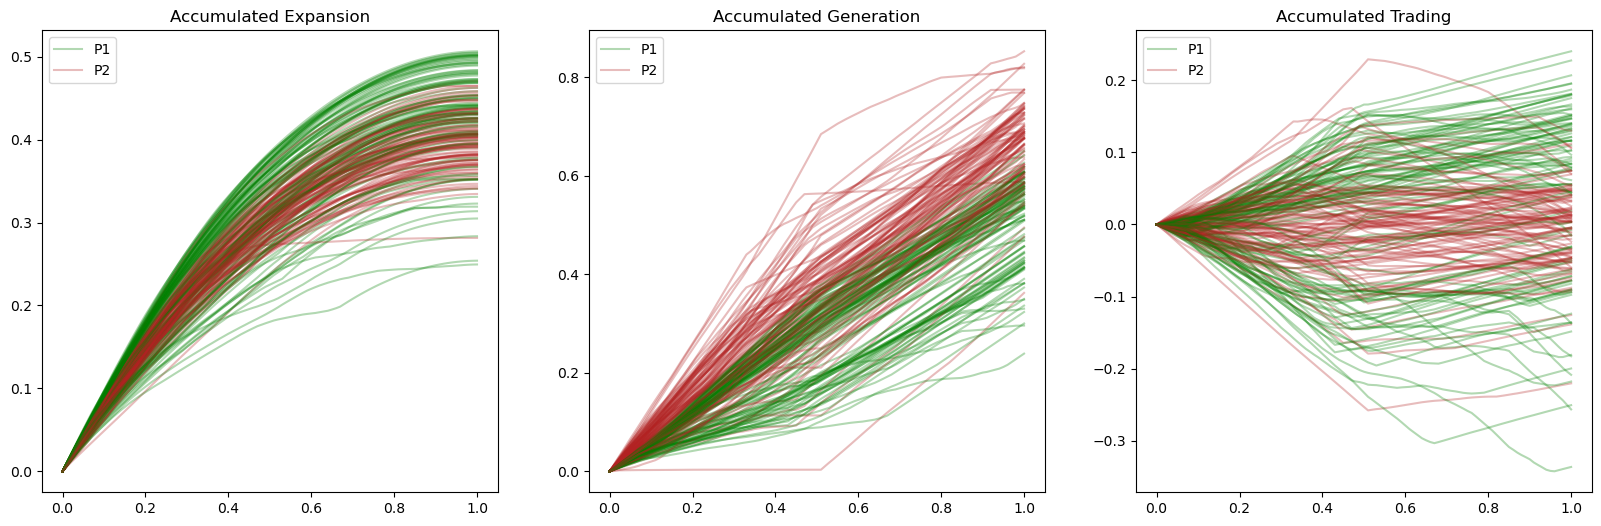

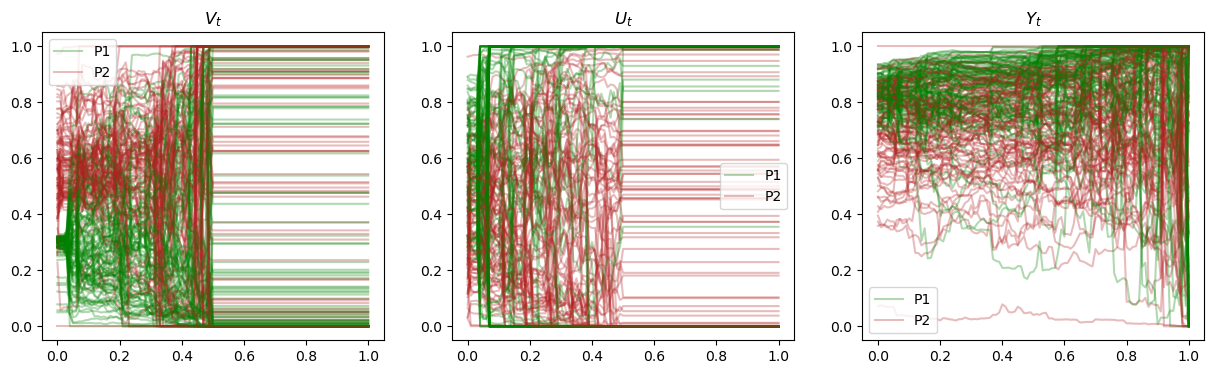

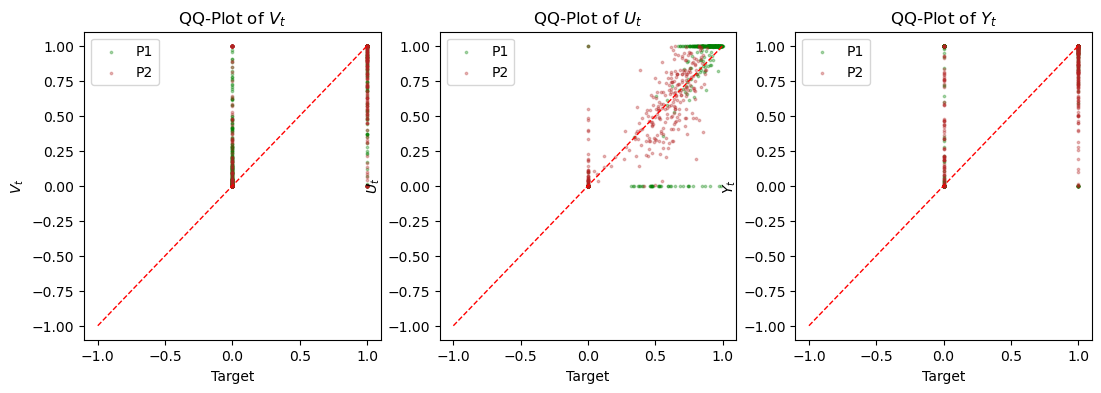

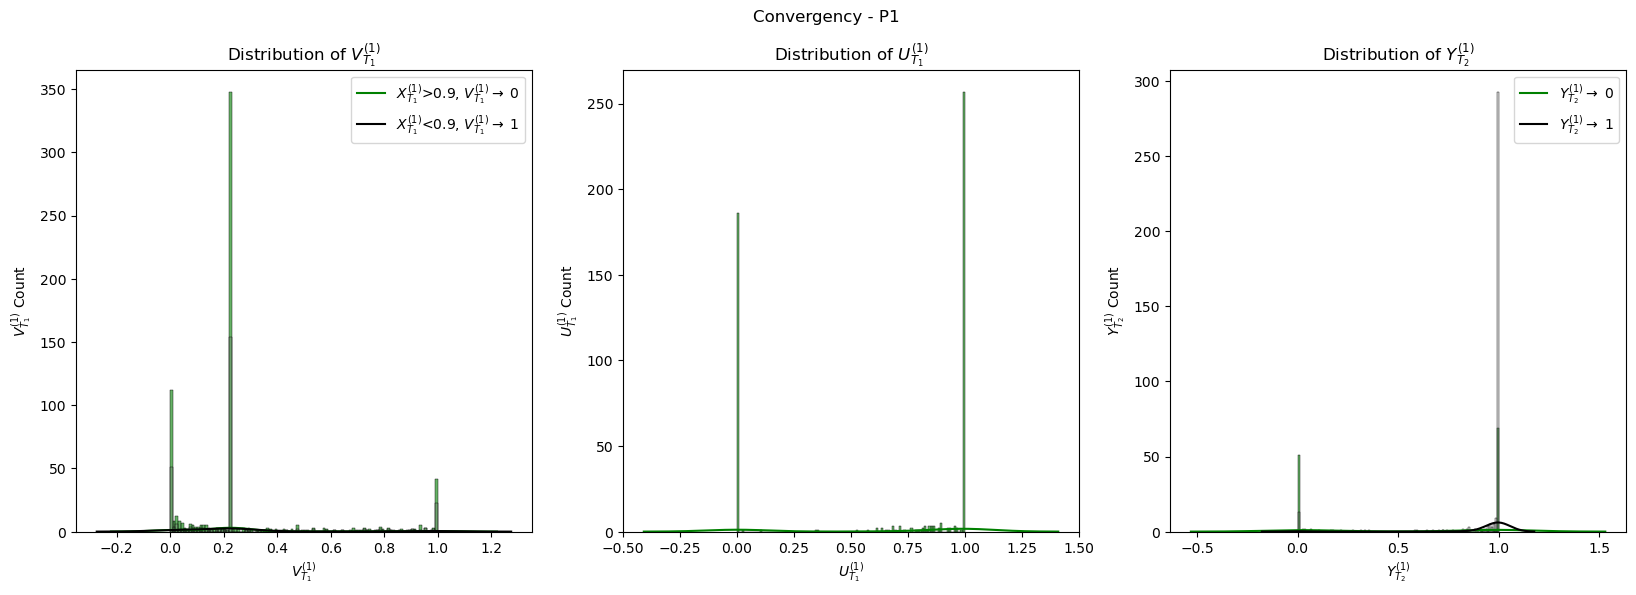

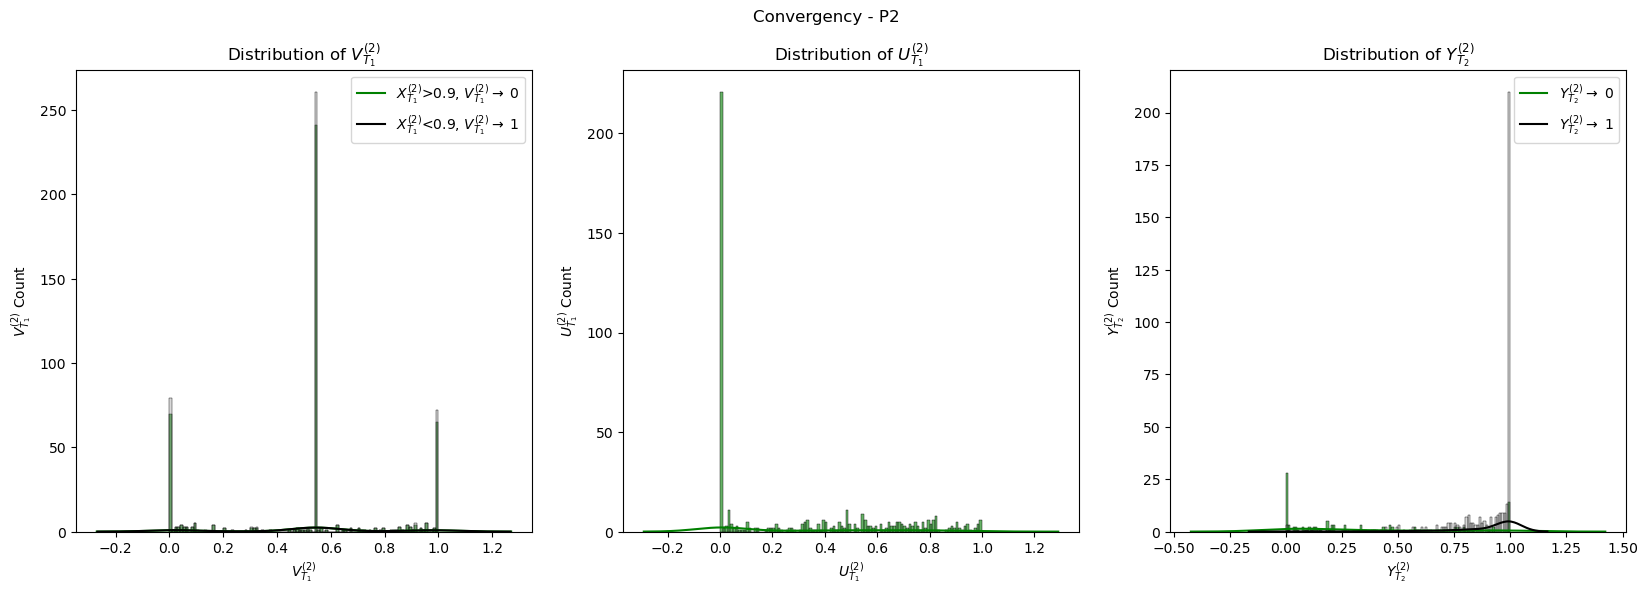

In [49]:
GlobalParams1=Params(param_type='k1',target_type='indicator',trick='clamp',loss_type='MSELoss',delta=0.03,w=1,lr=0.01)
GlobalParams2=Params(param_type='k2',target_type='indicator',trick='clamp',loss_type='MSELoss',delta=0.03,w=1,lr=0.01)
models1=Main_Models(GlobalParams=GlobalParams1)
models2=Main_Models(GlobalParams=GlobalParams2)
path_dir=pathlib.Path(os.getcwd(),
                      "Results",
                      "Best Models Saved",
                      'minmax_ind_0.01lr_300steps_MSE_1w')
path1=pathlib.Path(path_dir,'pop1.pt')
path2=pathlib.Path(path_dir,'pop2.pt')
model_dict1=models1.load_entire_models(path=path1,overwrite=True)
model_dict2=models2.load_entire_models(path=path2,overwrite=True)

dB1=model_dict1['dB']
init_x1=model_dict1['init_x']
init_c1=model_dict1['init_c']
pop1_dict= {'dB':dB1,
            'init_x':init_x1,
            'init_c':init_c1,
            'GlobalParams':GlobalParams1, 
            'main_models':models1}

dB2=model_dict2['dB']
init_x2=model_dict2['init_x']
init_c2=model_dict2['init_c']

pop2_dict= {'dB':dB2,
            'init_x':init_x2 ,
            'init_c':init_c2 , 
            'GlobalParams':GlobalParams2, 
            'main_models':models2}
dt=GlobalParams1.dt
NT1=GlobalParams1.NT1
NT2=GlobalParams1.NT2
NumTrain=GlobalParams1.NumTrain
K=GlobalParams1.K
loss=models1.loss

models1.v0_model.scaler_type='minmax'
models1.u0_model.scaler_type='minmax'
models1.y0_model.scaler_type='minmax'
models2.v0_model.scaler_type='minmax'
models2.u0_model.scaler_type='minmax'
models2.y0_model.scaler_type='minmax'
for md in models1.zv_models:
    md.scaler_type=None
for md in models1.zu_models:
    md.scaler_type=None
for md in models1.zy_models:
    md.scaler_type=None

for md in models2.zv_models:
    md.scaler_type=None
for md in models2.zu_models:
    md.scaler_type=None
for md in models2.zy_models:
    md.scaler_type=None


plot=plot_results(pop1_dict=pop1_dict,pop2_dict=pop2_dict,loss=loss)
plot.FwdLoss(log=True)
plot.Inventory_And_Price()
plot.Decomposition_Inventory()
plot.Key_Processes()
plot.Terminal_Convergence()

## Save The Models

In [51]:
# print(f"{len(main_models1.loss)} steps\nStarted @ {start_time}\nSaved @ {end_time}")   ## to examine whether the loss attribute is updated in the module insteance
dir_path=pathlib.Path(os.getcwd(),
                      'Results',
                      'Best Models Saved',
                      'minmax_ind_0.01lr_300steps_MSE_1w')
dir_path.mkdir()
path1=pathlib.Path(dir_path,'pop1.pt')
path2=pathlib.Path(dir_path,'pop2.pt')
models1.save_entire_models(path=path1)
models2.save_entire_models(path=path2)

- input to find cluster: `property type`, `property value`, `deductible`, `PML`

- input to find price: `XL_l_bound`, `XL_U_bound`, `premium`

$$
\begin{align}
\text{XL lower bound as \% of PML } &= \min {\Biggl(\frac{\text{ XL lower bound}}{\text{PML}},1 \Biggr) }\\
\text{Net Premium } &=\min {\Biggl(\frac{\text{ XL upper bound}}{PML},1 \Bigg) } * \text{PML} \\
\text{LER } &= \text{MMBBEFD}{\Bigg( \text{XL lower bound as \% of PML } \Biggr) }\\
\text{Layer Premium } &= (1-\text{LER }) * \text{Net Premium } \\
\end{align}
$$